In [26]:
pip install ucimlrepo


In [27]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,f1_score

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")  # Ignore warning messages during code execution

abalone = fetch_ucirepo(id=1)

X = abalone.data.features
y = abalone.data.targets

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import _tree
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score



# Part A

## 1

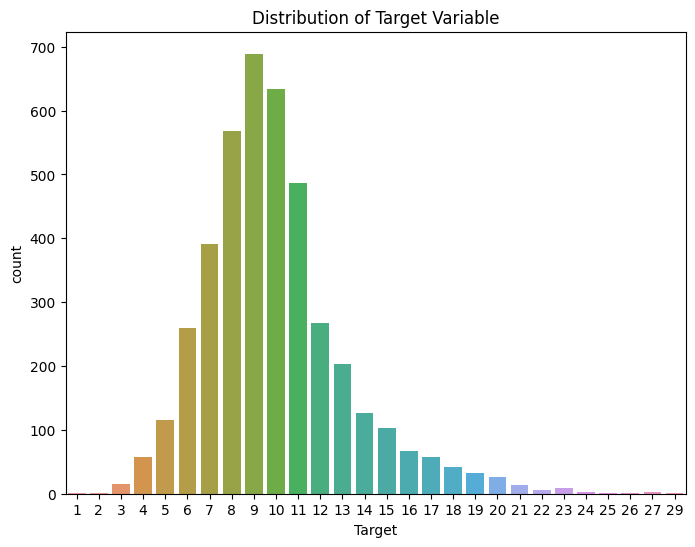

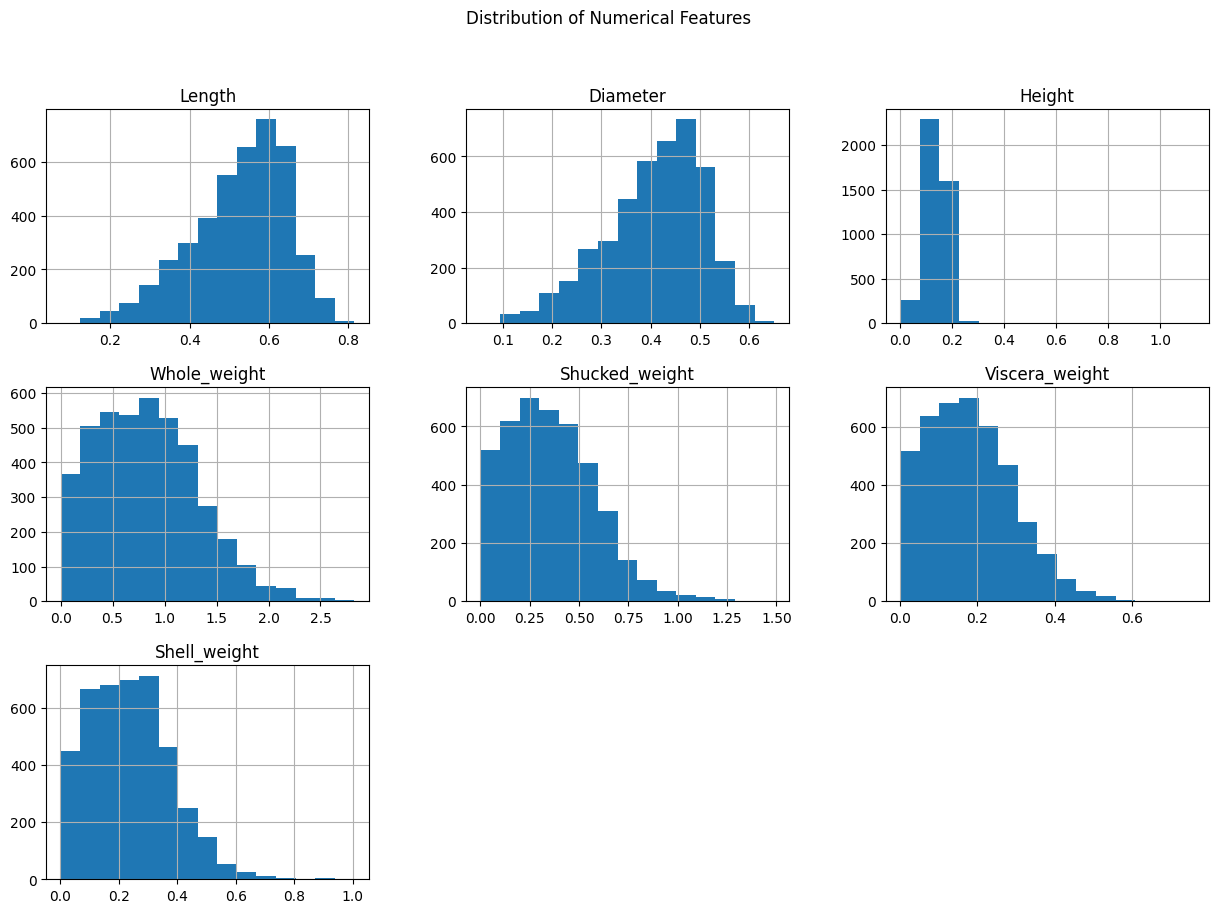

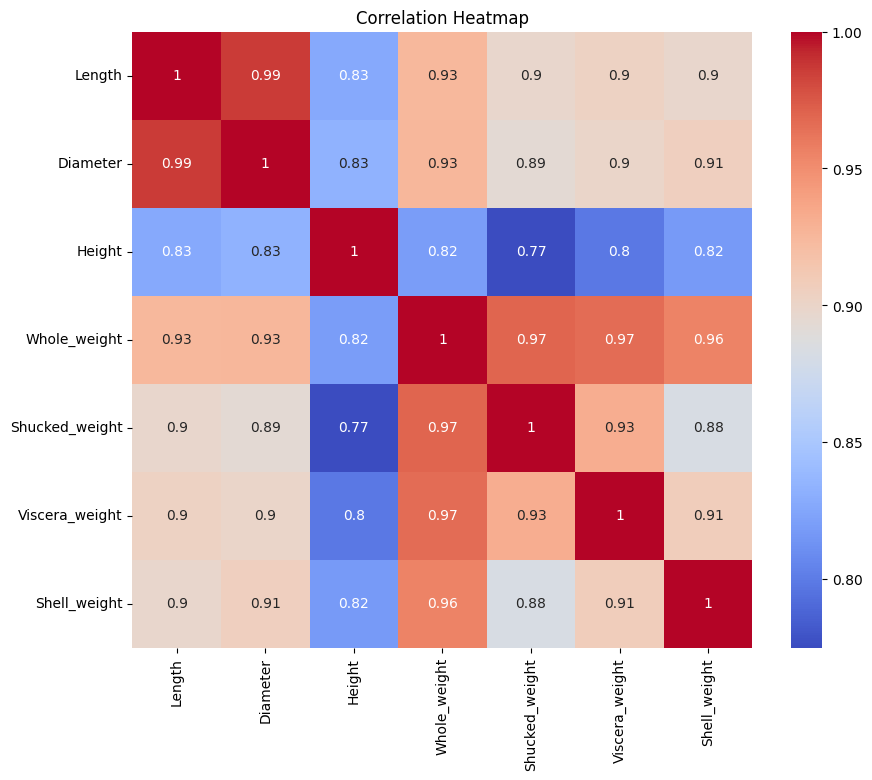

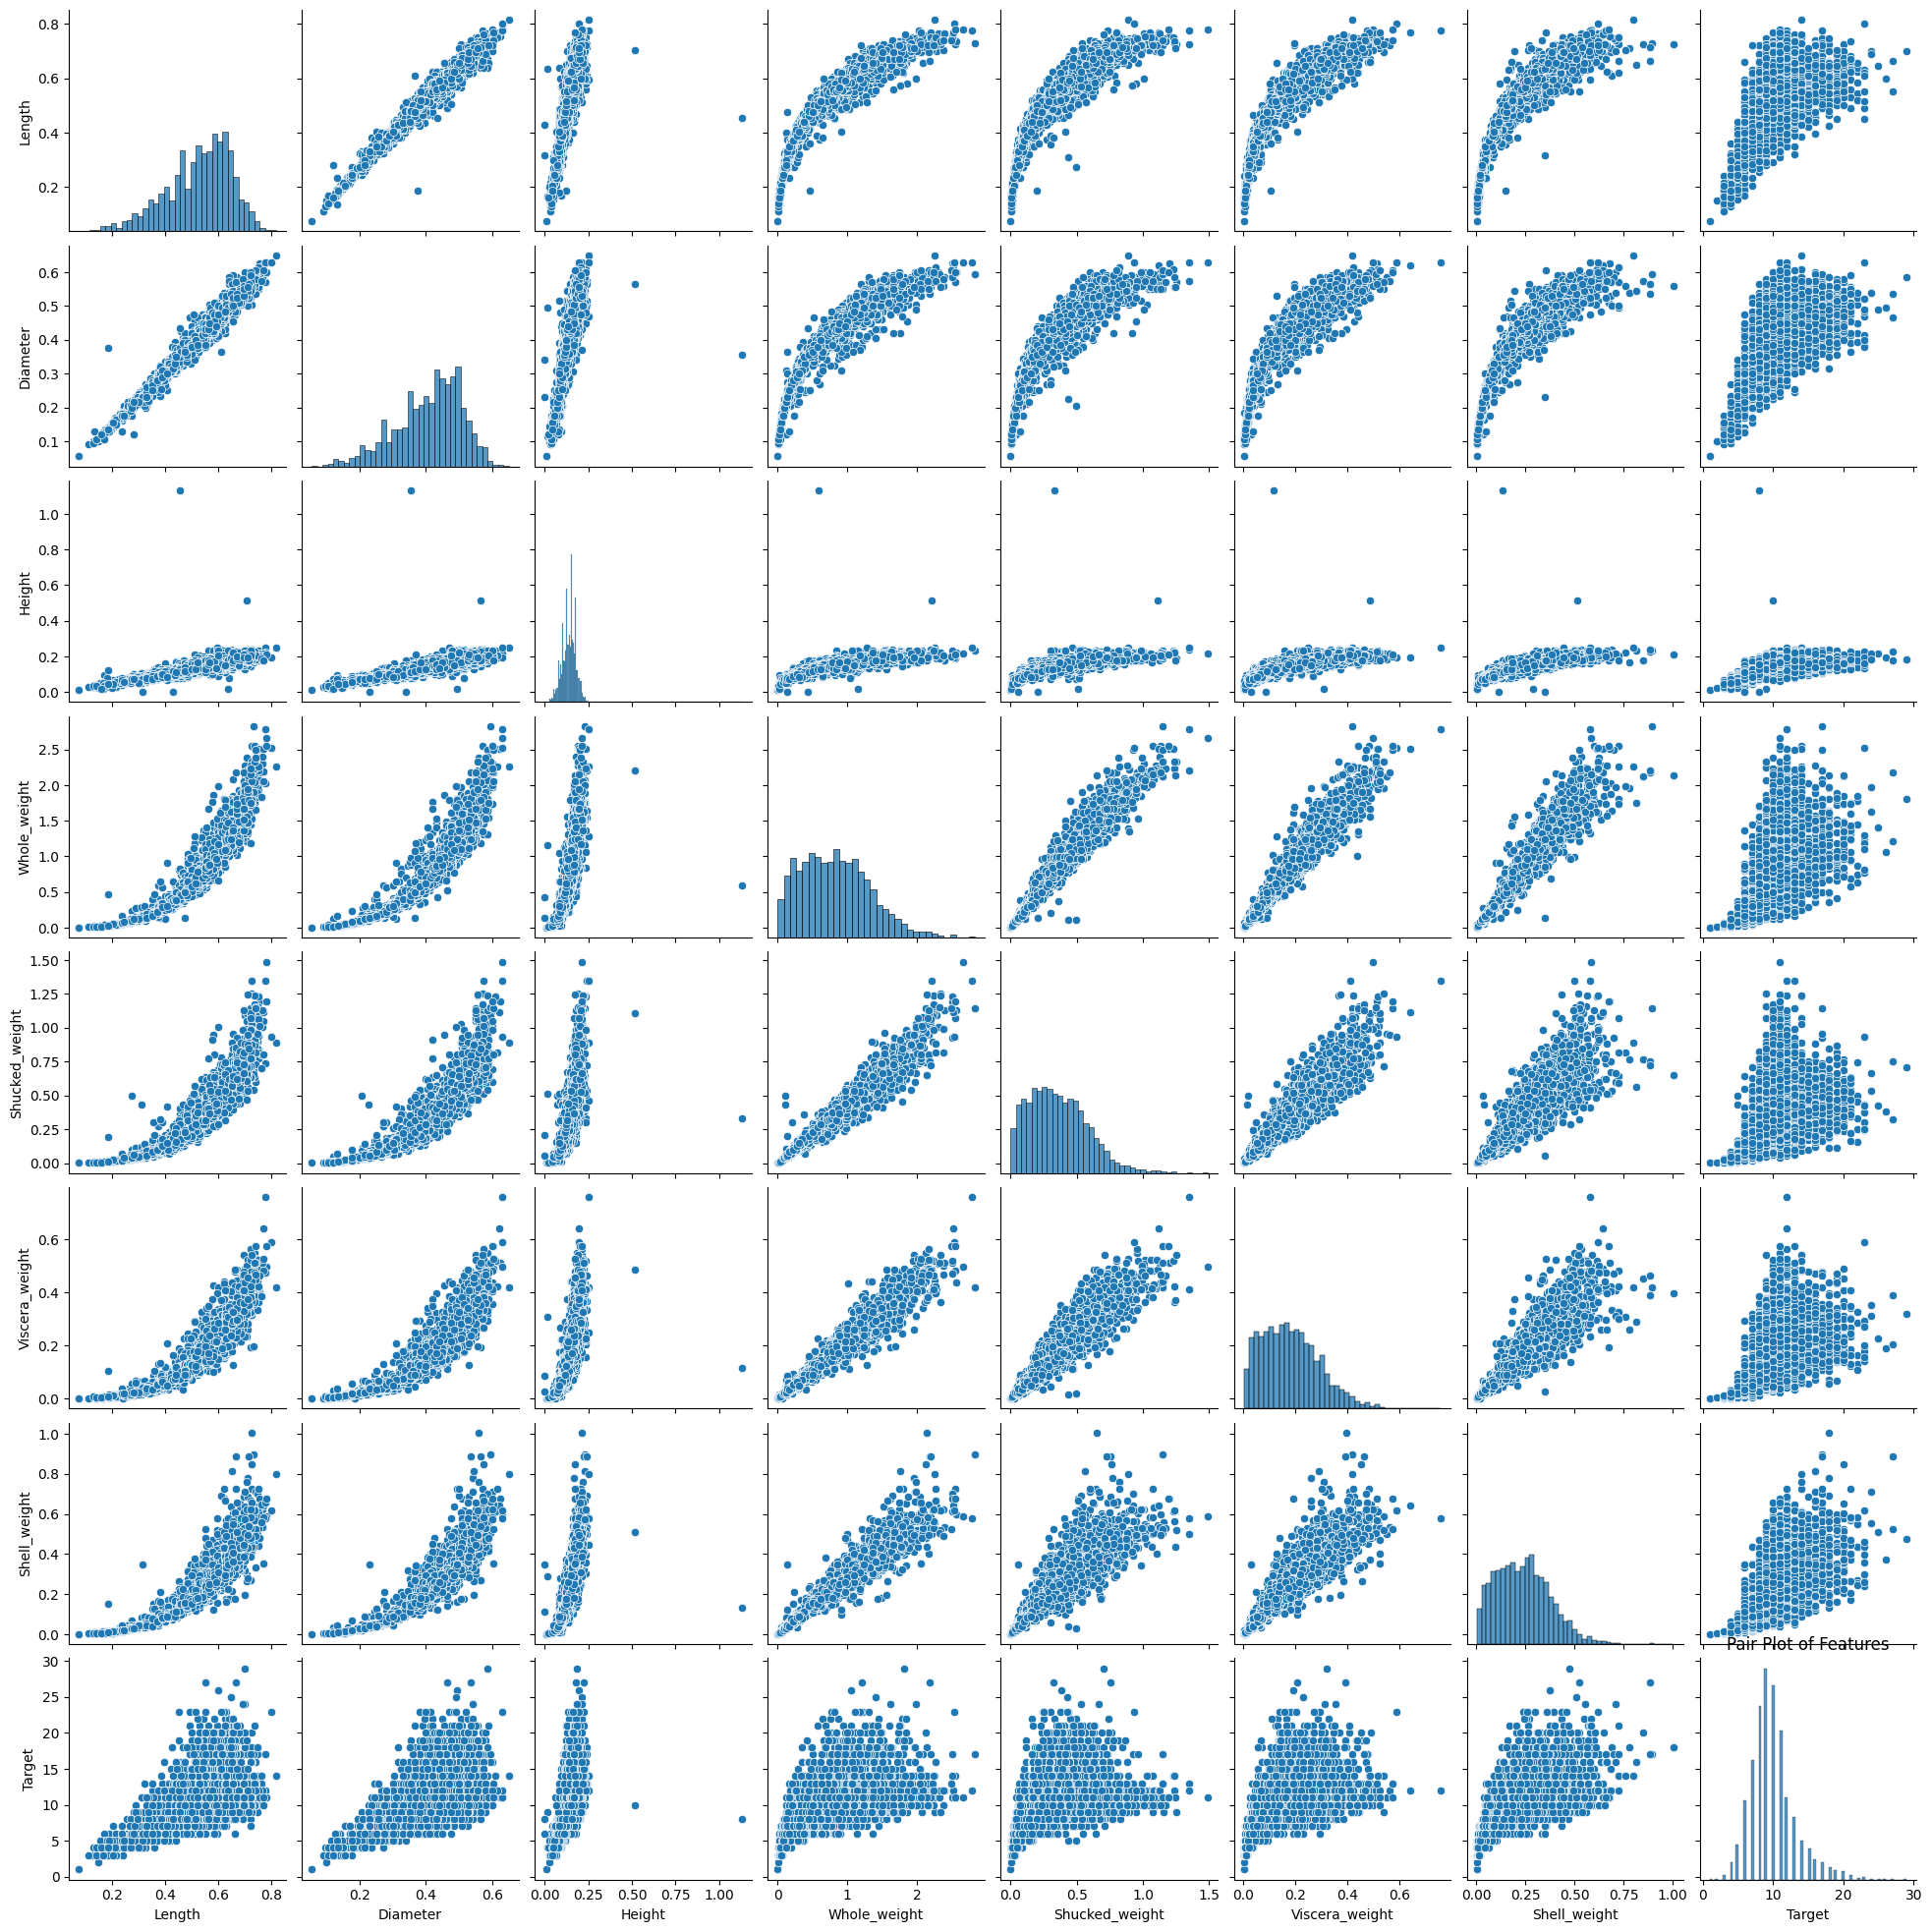

In [29]:
abalone_df = pd.DataFrame(X)
abalone_df['Target'] = y  # Assuming 'y' is a single target column


# Distribution of target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='Target', data=abalone_df)
plt.title('Distribution of Target Variable')
plt.show()

# Distribution of numerical features
numerical_features = abalone_df.select_dtypes(include=['float64', 'int64']).columns.drop('Target')
abalone_df[numerical_features].hist(bins=15, figsize=(15, 10), layout=(3, 3))
plt.suptitle('Distribution of Numerical Features')
plt.show()

# Correlation heatmap
correlation_matrix = abalone_df[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Pair plot
sns.pairplot(abalone_df, markers=["o", "s", "D"])
plt.title('Pair Plot of Features')
plt.show()

## 2

In [30]:

X_partA = X.copy()

def age2class(age):
    if age <= 7:
        return 1
    elif 8 <= age <= 10:
        return 2
    elif 11 <= age <= 15:
        return 3
    else:
        return 4

y_partA = y['Rings'].apply(age2class)


columns = ["Sex", "Length", "Diameter", "Height", "Whole weight",
           "Shucked weight", "Viscera weight", "Shell weight", "Rings"]
X_partA.columns = columns

X_partA = pd.get_dummies(X_partA, columns=['Sex'])

X_partA = X_partA.drop('Rings', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_partA, y_partA, test_size=0.4, random_state=100)



In [31]:
# 初始化最佳模型记录
best_accuracy = 0
best_params = {}
best_f1_train = 0
best_f1_test = 0

# 迭代不同的参数值
for depth in range(1, 10):  # 添加 max_depth 的循环
    for split in range(2, 10):
        for leaf in range(2, 10):
            # 训练决策树模型
            dt_classifier = DecisionTreeClassifier(max_depth=depth,
                                  min_samples_split=split,
                                  min_samples_leaf=leaf)
            dt_classifier.fit(X_train, y_train)

            # 预测并计算性能指标
            y_test_pred = dt_classifier.predict(X_test)
            accuracy = accuracy_score(y_test, y_test_pred)
            f1_test = f1_score(y_test, y_test_pred, average='weighted')

            # 检查是否为最佳模型
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {
                    'max_depth': depth,
                    'min_samples_split': split,
                    'min_samples_leaf': leaf
                }
                best_f1_test = f1_test
                y_train_pred = dt_classifier.predict(X_train)
                best_f1_train = f1_score(y_train, y_train_pred, average='weighted')

# 输出最佳模型的参数和性能指标
print("Best Tree Parameters:", best_params)
print(f"Best Test Accuracy: {best_accuracy:.4f}")
print(f"Best F1 Score on Train: {best_f1_train:.4f}")
print(f"Best F1 Score on Test: {best_f1_test:.4f}")

Best Tree Parameters: {'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 7}
Best Test Accuracy: 0.6212
Best F1 Score on Train: 0.6509
Best F1 Score on Test: 0.6018


## 3

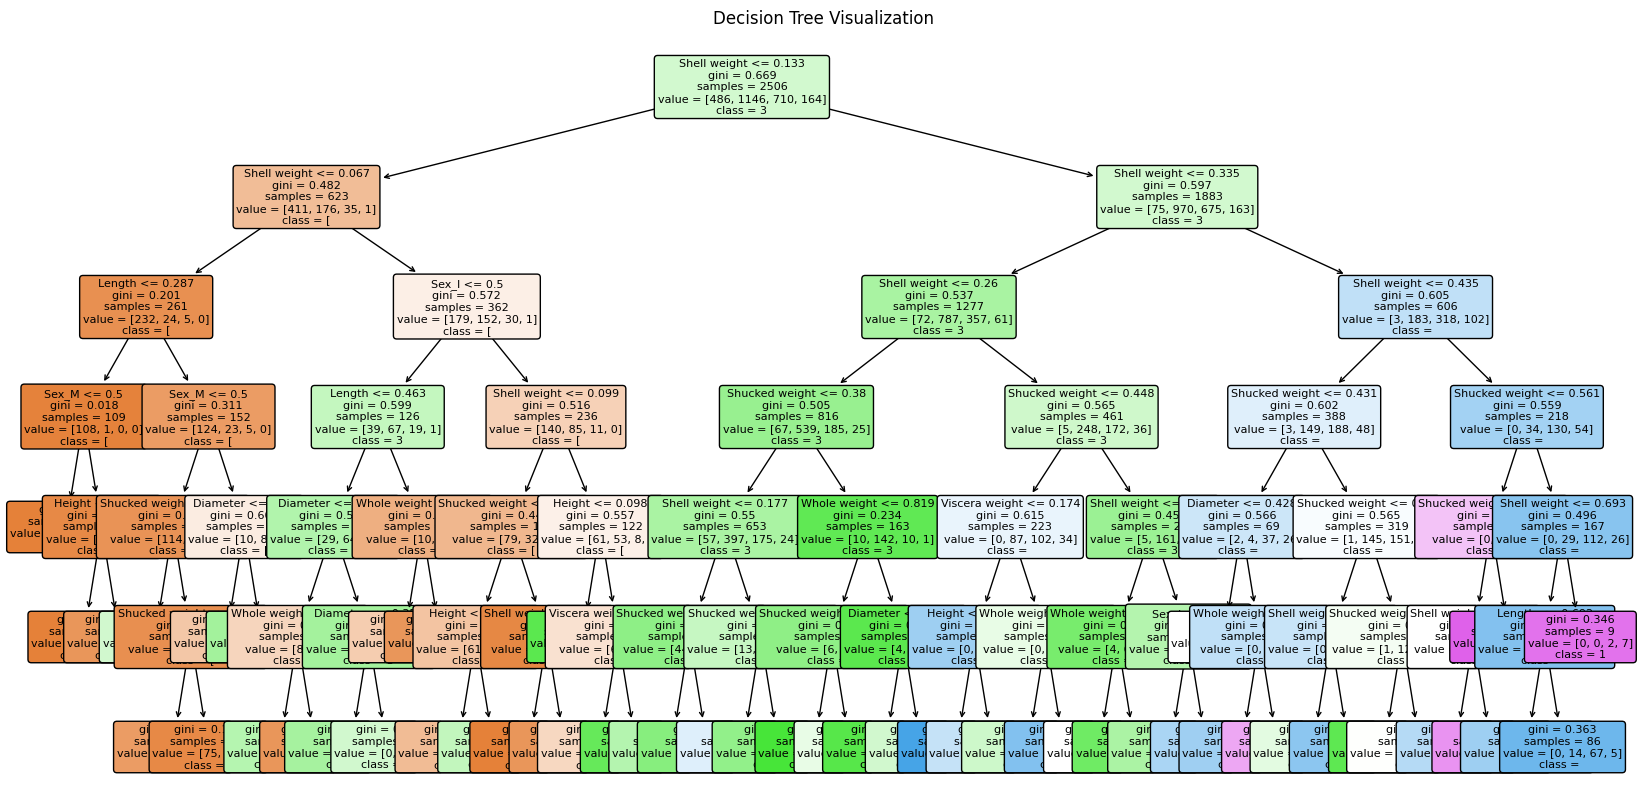

IF Shell weight <= 0.13
IF Shell weight <= 0.07
IF Length <= 0.29
IF Sex_M <= 0.50
THEN Predicted class: 1


In [32]:
# 创建决策树模型
dt_classifier = DecisionTreeClassifier(**best_params)
dt_classifier.fit(X_train, y_train)

# 树的可视化
plt.figure(figsize=(20,10))
plot_tree(dt_classifier,
          feature_names=X_partA.columns,
          class_names=str(y_partA.unique()),
          filled=True,
          rounded=True,
          fontsize=8)
plt.title("Decision Tree Visualization")
plt.show()


# Function to extract rules from the decision tree
def extract_rules(tree, feature_names, node_index=0, simple_path=True, depth=0, max_depth=3):
    # 确保不超过最大深度
    if depth > max_depth:
        return

    # 叶子节点
    if tree.tree_.children_left[node_index] == _tree.TREE_LEAF:
        print(f"THEN Predicted class: {tree.classes_[np.argmax(tree.tree_.value[node_index])]}")
        return

    # 决策节点
    feature = feature_names[tree.tree_.feature[node_index]]
    threshold = tree.tree_.threshold[node_index]
    print(f"IF {feature} <= {threshold:.2f}")

    # 左子树
    extract_rules(tree, feature_names, tree.tree_.children_left[node_index], simple_path, depth + 1, max_depth)

    # 右子树
    if not simple_path:
        print("ELSE")
        extract_rules(tree, feature_names, tree.tree_.children_right[node_index], simple_path, depth + 1, max_depth)

# 提取并打印规则
extract_rules(dt_classifier, X_train.columns, max_depth=5)


## 4

In [33]:
# 训练带有特定预剪枝参数的决策树
initial_tree = DecisionTreeClassifier(**best_params, random_state=100)
initial_tree.fit(X_train, y_train)

# 获取剪枝路径
path = initial_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# 评估每个 alpha 下树的交叉验证性能
alpha_scores = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=100, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf, X_train, y_train, cv=5)  # 5-fold cross-validation
    alpha_scores.append(np.mean(scores))

# 选择最佳 alpha
best_alpha = ccp_alphas[np.argmax(alpha_scores)]
print("Best alpha: ", best_alpha)

# 使用最佳 alpha 值训练决策树
best_pruned_tree = DecisionTreeClassifier(random_state=100, ccp_alpha=best_alpha)
best_pruned_tree.fit(X_train, y_train)


# 对训练集和测试集进行预测
y_train_pred = best_pruned_tree.predict(X_train)
y_test_pred = best_pruned_tree.predict(X_test)

# 计算准确率
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# 计算 F1 分数
f1_train = f1_score(y_train, y_train_pred, average='weighted')
f1_test = f1_score(y_test, y_test_pred, average='weighted')

# 输出结果
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"F1 Score on Train: {f1_train:.4f}")
print(f"F1 Score on Test: {f1_test:.4f}")

Best alpha:  0.0017030555238855306
Train Accuracy: 0.6544
Test Accuracy: 0.6314
F1 Score on Train: 0.6481
F1 Score on Test: 0.6217


In [51]:
# 创建并训练随机森林模型
rf_classifier = RandomForestClassifier(
    n_estimators=300,             # 树的数量
    max_depth=6,                  # 最佳树的最大深度
    min_samples_split=2,          # 最佳树的最小样本分裂
    min_samples_leaf=7,           # 最佳树的最小样本叶子
    random_state=100
)

# 训练模型
rf_classifier.fit(X_train, y_train)

# 预测并计算性能指标
y_train_pred_rf = rf_classifier.predict(X_train)
y_test_pred_rf = rf_classifier.predict(X_test)
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
f1_train_rf = f1_score(y_train, y_train_pred_rf, average='weighted')
f1_test_rf = f1_score(y_test, y_test_pred_rf, average='weighted')

# 输出随机森林的性能指标
print(f"Random Forest Train Accuracy: {train_accuracy_rf:.4f}")
print(f"Random Forest Test Accuracy: {test_accuracy_rf:.4f}")
print(f"Random Forest F1 Score on Train: {f1_train_rf:.4f}")
print(f"Random Forest F1 Score on Test: {f1_test_rf:.4f}")


Random Forest Train Accuracy: 0.3915
Random Forest Test Accuracy: 0.2735
Random Forest F1 Score on Train: 0.3534
Random Forest F1 Score on Test: 0.2391


## 5

In [52]:
# 创建 DataFrame
df = pd.DataFrame(X_partA)
df['y'] = y_partA  # 假设 y_partA 是目标变量

# 删除只有一个样本的类别
df_filtered = df.groupby('y').filter(lambda x: len(x) > 1)

# 分离特征和目标变量
X_filtered = df_filtered.drop('y', axis=1)
y_filtered = df_filtered['y']

label_encoder = LabelEncoder()
y_filtered_encoded = label_encoder.fit_transform(y_filtered)

# 使用分层抽样来分割数据集
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_filtered, y_filtered_encoded, test_size=0.4, random_state=100, stratify=y_filtered_encoded
)

# 然后您可以继续训练 XGBoost 分类器
xgb_classifier = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=100,
    max_depth=6,  # 最佳树的最大深度
    min_child_weight=2,  # 这里假设 min_samples_split 约等于 min_child_weight
    max_delta_step=7,  # 这里假设 min_samples_leaf 约等于 max_delta_step
)
xgb_classifier.fit(X_train_new, y_train_new)

# 对训练集和测试集进行预测
y_train_pred_xgb = xgb_classifier.predict(X_train_new)
y_test_pred_xgb = xgb_classifier.predict(X_test_new)

# 计算准确率和 F1 分数
train_accuracy_xgb = accuracy_score(y_train_new, y_train_pred_xgb)
test_accuracy_xgb = accuracy_score(y_test_new, y_test_pred_xgb)
f1_train_xgb = f1_score(y_train_new, y_train_pred_xgb, average='weighted')
f1_test_xgb = f1_score(y_test_new, y_test_pred_xgb, average='weighted')

# 输出结果
print(f"XGBoost Train Accuracy: {train_accuracy_xgb:.4f}")
print(f"XGBoost Test Accuracy: {test_accuracy_xgb:.4f}")
print(f"XGBoost F1 Score on Train: {f1_train_xgb:.4f}")
print(f"XGBoost F1 Score on Test: {f1_test_xgb:.4f}")


XGBoost Train Accuracy: 0.9749
XGBoost Test Accuracy: 0.6152
XGBoost F1 Score on Train: 0.9748
XGBoost F1 Score on Test: 0.6121


In [53]:
# 创建 Gradient Boosting 分类器
gb_classifier = GradientBoostingClassifier(
    random_state=100,
    max_depth=6,            # 最佳树的最大深度
    min_samples_split=2,    # 最佳树的最小样本分裂
    min_samples_leaf=7      # 最佳树的最小样本叶子
)
gb_classifier.fit(X_train_new, y_train_new)

# 对训练集和测试集进行预测
y_train_pred_gb = gb_classifier.predict(X_train_new)
y_test_pred_gb = gb_classifier.predict(X_test_new)

# 计算准确率和 F1 分数
train_accuracy_gb = accuracy_score(y_train_new, y_train_pred_gb)
test_accuracy_gb = accuracy_score(y_test_new, y_test_pred_gb)
f1_train_gb = f1_score(y_train_new, y_train_pred_gb, average='weighted')
f1_test_gb = f1_score(y_test_new, y_test_pred_gb, average='weighted')

# 输出结果
print(f"Gradient Boosting Train Accuracy: {train_accuracy_gb:.4f}")
print(f"Gradient Boosting Test Accuracy: {test_accuracy_gb:.4f}")
print(f"Gradient Boosting F1 Score on Train: {f1_train_gb:.4f}")
print(f"Gradient Boosting F1 Score on Test: {f1_test_gb:.4f}")


Gradient Boosting Train Accuracy: 0.9565
Gradient Boosting Test Accuracy: 0.6164
Gradient Boosting F1 Score on Train: 0.9562
Gradient Boosting F1 Score on Test: 0.6124


## 6

In [37]:


# 创建基于 Adam 优化器的 MLP 分类器
mlp_adam = MLPClassifier(solver='adam', random_state=100, max_iter=1000)
mlp_adam.fit(X_train_new, y_train_new)

# 对训练集和测试集进行预测
y_train_pred_adam = mlp_adam.predict(X_train_new)
y_test_pred_adam = mlp_adam.predict(X_test_new)

# 计算准确率和 F1 分数
train_accuracy_adam = accuracy_score(y_train_new, y_train_pred_adam)
test_accuracy_adam = accuracy_score(y_test_new, y_test_pred_adam)
f1_train_adam = f1_score(y_train_new, y_train_pred_adam, average='weighted')
f1_test_adam = f1_score(y_test_new, y_test_pred_adam, average='weighted')

# 输出结果
print(f"MLP with Adam - Train Accuracy: {train_accuracy_adam:.4f}")
print(f"MLP with Adam - Test Accuracy: {test_accuracy_adam:.4f}")
print(f"MLP with Adam - F1 Score on Train: {f1_train_adam:.4f}")
print(f"MLP with Adam - F1 Score on Test: {f1_test_adam:.4f}")

print('==========')

# 创建基于 SGD 优化器的 MLP 分类器
mlp_sgd = MLPClassifier(solver='sgd', random_state=100, max_iter=1000)
mlp_sgd.fit(X_train_new, y_train_new)

# 对训练集和测试集进行预测
y_train_pred_sgd = mlp_sgd.predict(X_train_new)
y_test_pred_sgd = mlp_sgd.predict(X_test_new)

# 计算准确率和 F1 分数
train_accuracy_sgd = accuracy_score(y_train_new, y_train_pred_sgd)
test_accuracy_sgd = accuracy_score(y_test_new, y_test_pred_sgd)
f1_train_sgd = f1_score(y_train_new, y_train_pred_sgd, average='weighted')
f1_test_sgd = f1_score(y_test_new, y_test_pred_sgd, average='weighted')

# 输出结果
print(f"MLP with SGD - Train Accuracy: {train_accuracy_sgd:.4f}")
print(f"MLP with SGD - Test Accuracy: {test_accuracy_sgd:.4f}")
print(f"MLP with SGD - F1 Score on Train: {f1_train_sgd:.4f}")
print(f"MLP with SGD - F1 Score on Test: {f1_test_sgd:.4f}")



MLP with Adam - Train Accuracy: 0.6496
MLP with Adam - Test Accuracy: 0.6655
MLP with Adam - F1 Score on Train: 0.6402
MLP with Adam - F1 Score on Test: 0.6594
MLP with SGD - Train Accuracy: 0.6002
MLP with SGD - Test Accuracy: 0.5978
MLP with SGD - F1 Score on Train: 0.5647
MLP with SGD - F1 Score on Test: 0.5629


# Part B

In [38]:
abalone = fetch_ucirepo(id=1)

X = abalone.data.features
y = abalone.data.targets

In [39]:
X_partB = pd.get_dummies(pd.DataFrame(X), columns=['Sex'])
X_partB

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Sex_F,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,0,1,0
...,...,...,...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,1,0,0
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,0,0,1
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,0,0,1
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,1,0,0


## 1

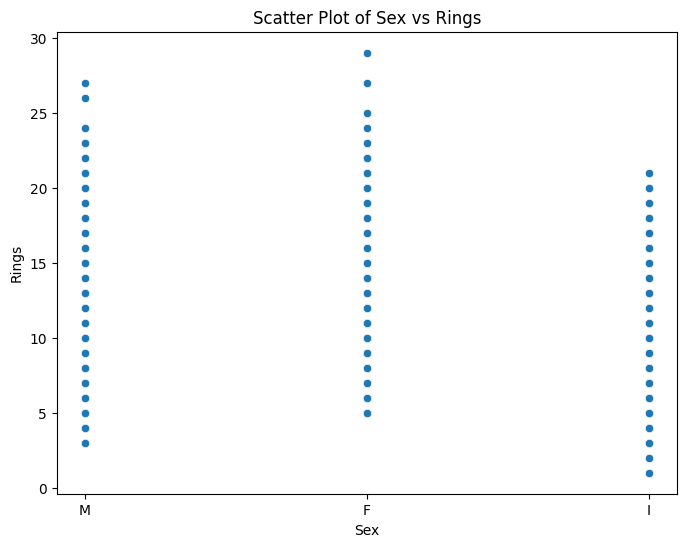

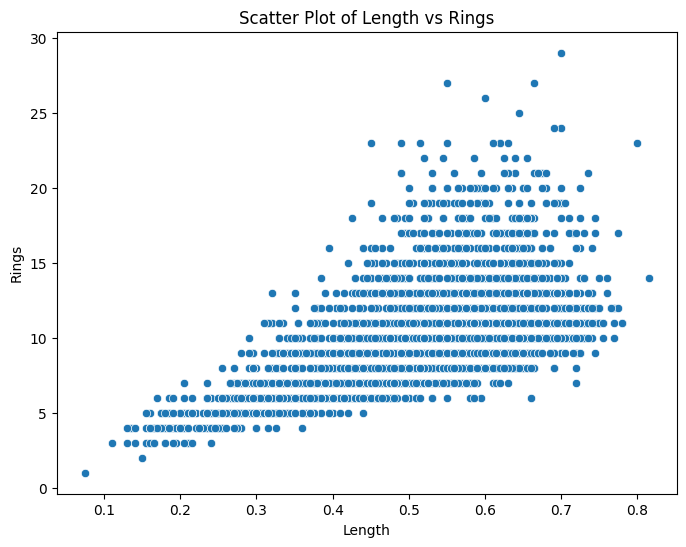

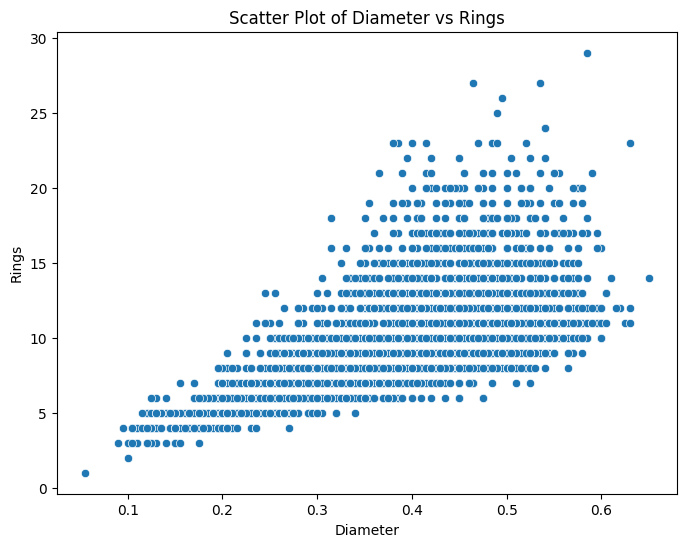

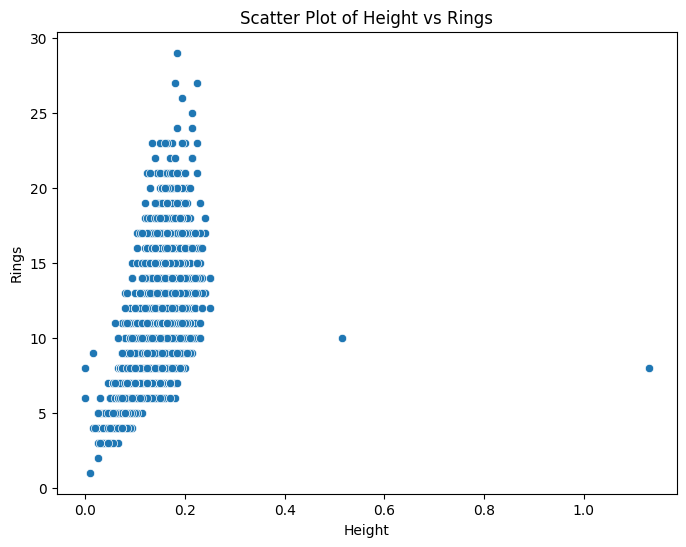

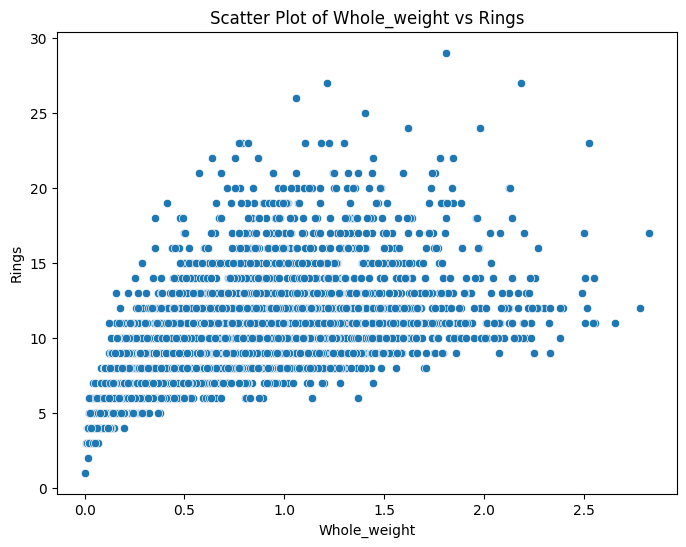

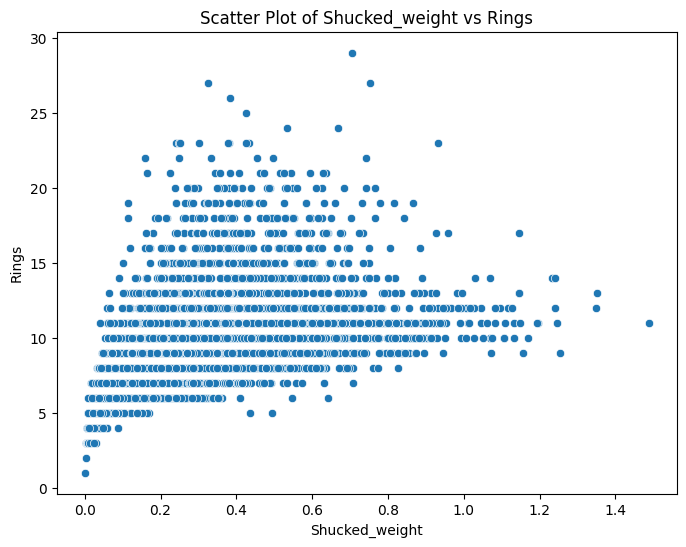

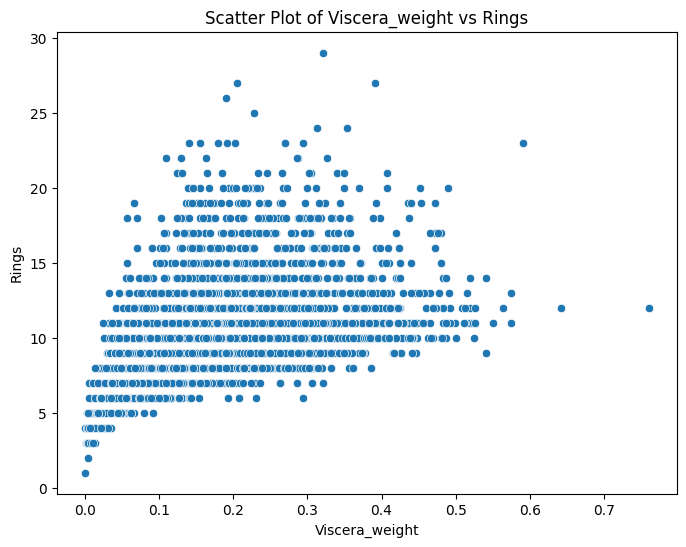

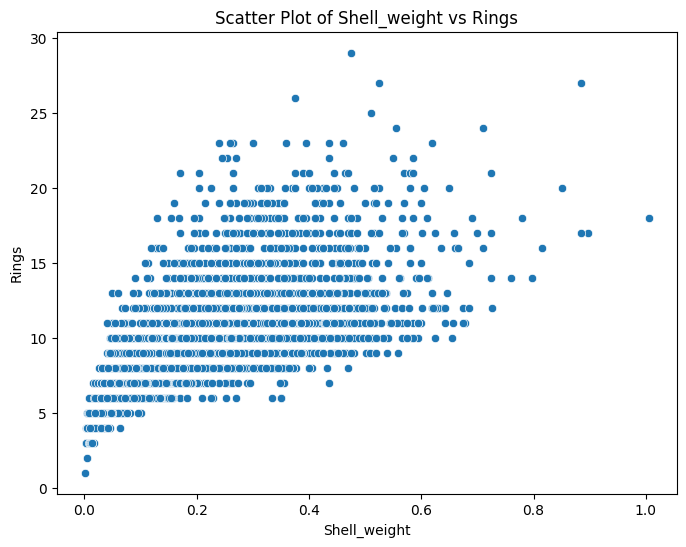

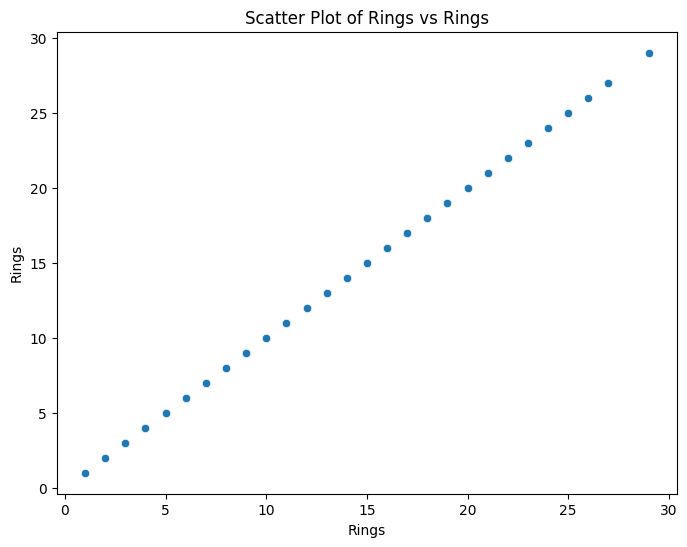

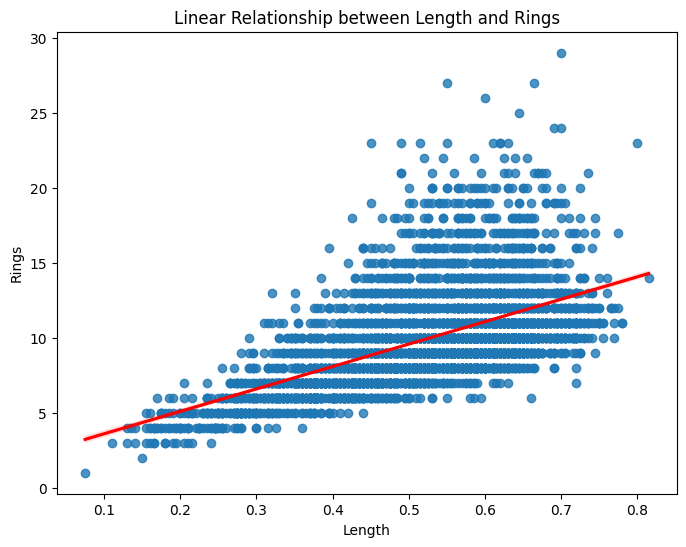

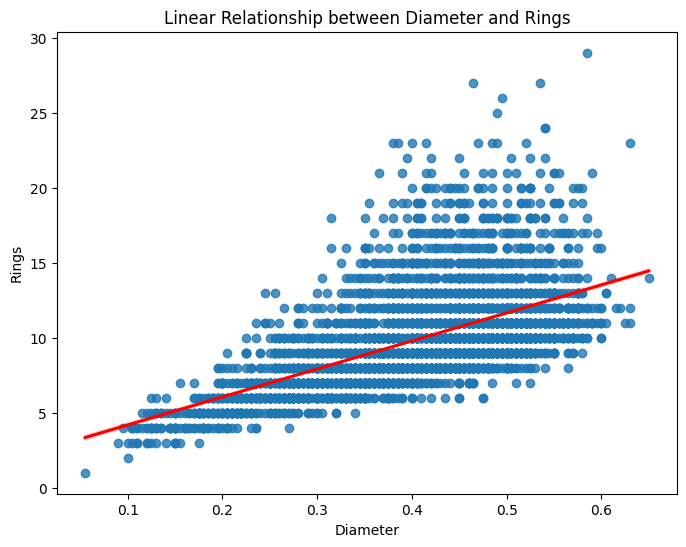

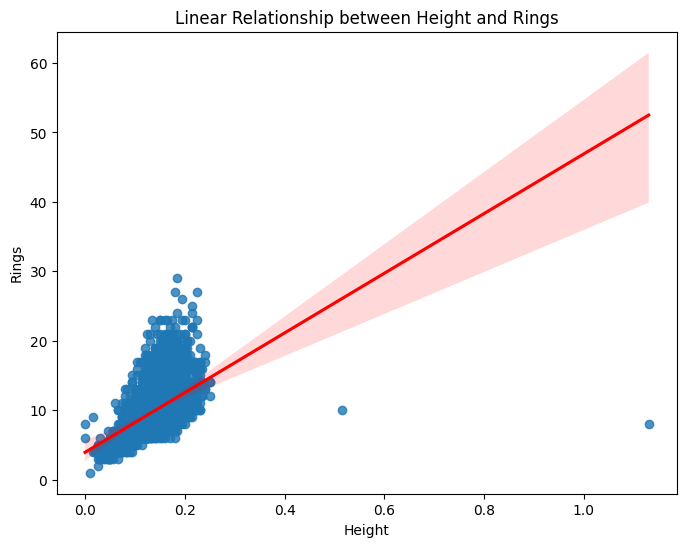

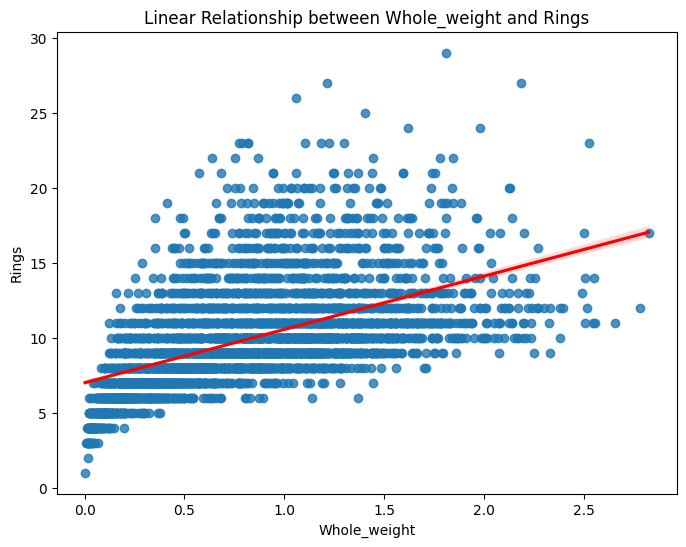

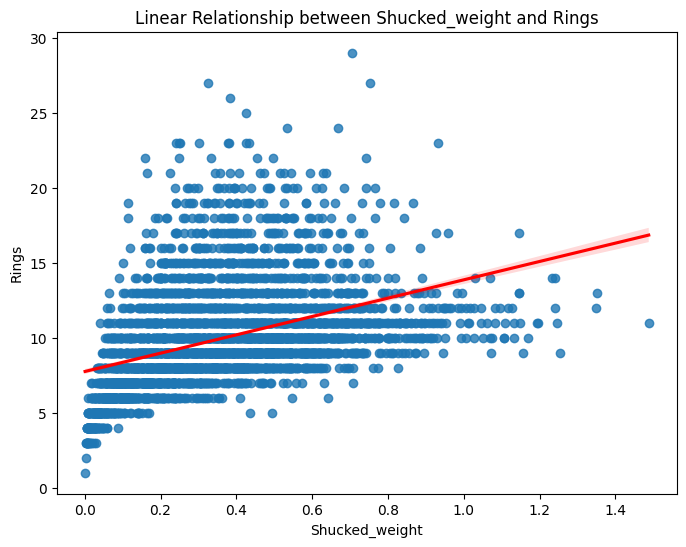

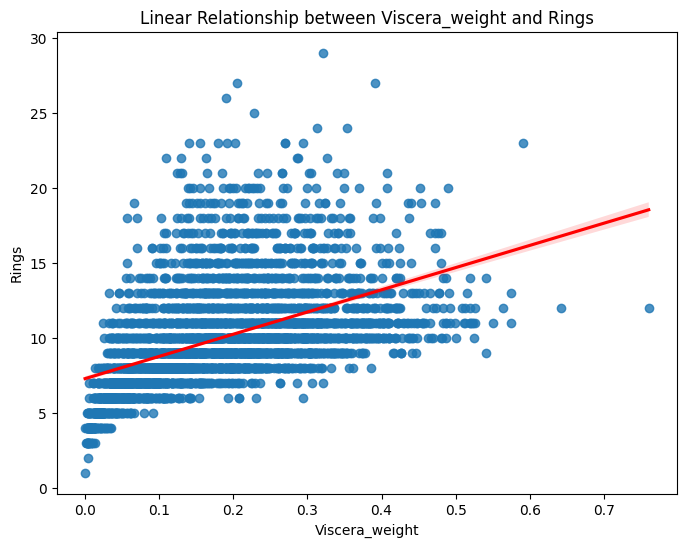

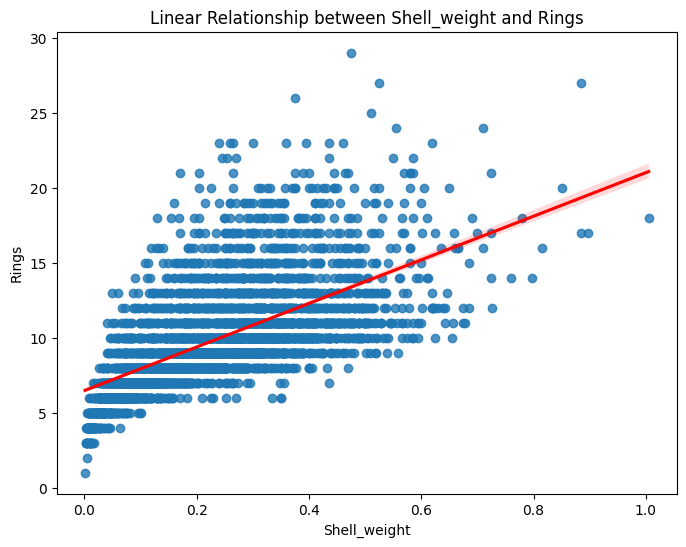

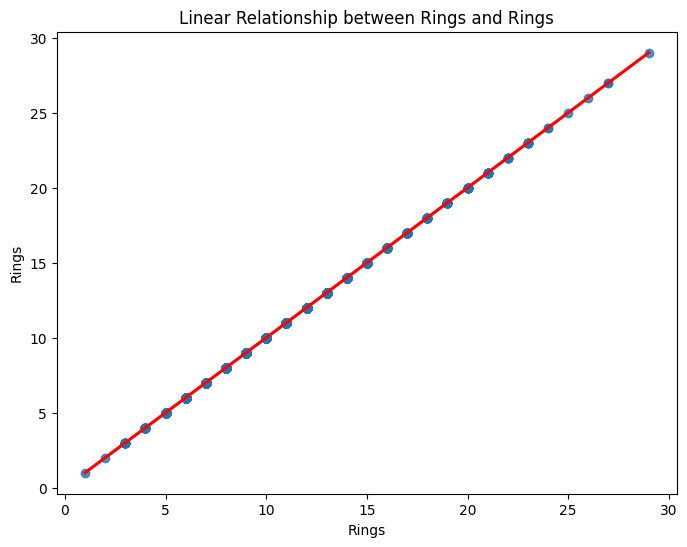

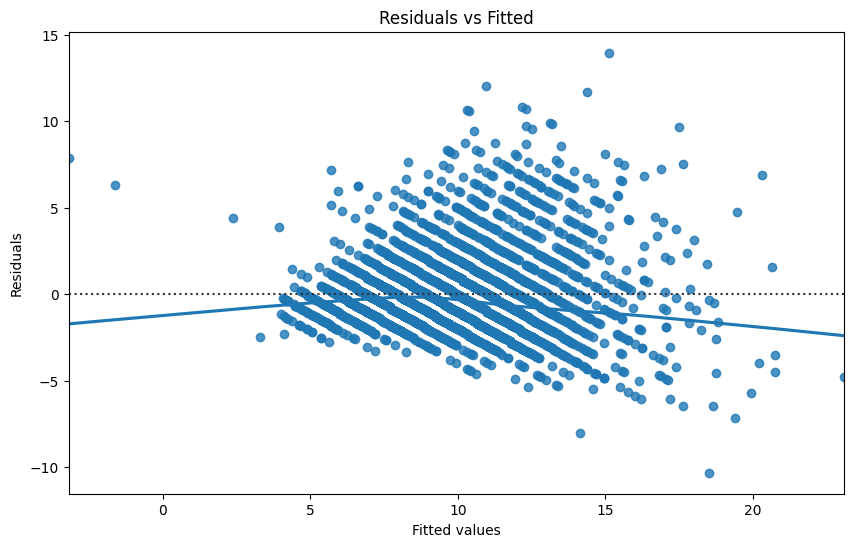

In [40]:


X['Rings'] = y
# 绘制特征与目标变量的散点图
for col in X.columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=col, y='Rings', data=X)
    plt.title(f'Scatter Plot of {col} vs Rings')
    plt.show()

# 绘制特征与目标变量的线性关系图
for col in X.columns.drop('Sex'):
    plt.figure(figsize=(8, 6))
    sns.regplot(x=col, y='Rings', data=X, line_kws={"color": "red"})
    plt.title(f'Linear Relationship between {col} and Rings')
    plt.show()

# 残差图的绘制通常需要模型的预测值，以下是一个简单线性回归模型的例子


model = LinearRegression()

model.fit(X_partB, y)
predictions = model.predict(X_partB)

# 绘制残差图
plt.figure(figsize=(10, 6))
sns.residplot(x=predictions, y=y, lowess=True)
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

## 2

In [41]:
# 分割数据为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_partB, y, test_size=0.4, random_state=100)

# 初始化最佳模型记录
best_r2 = -100
best_params = {}

# 迭代不同的参数值
for depth in range(1, 10):  # 添加 max_depth 的循环
    for split in range(2, 10):
        for leaf in range(2, 10):
            # 训练决策树模型
            dt_regressor = DecisionTreeRegressor(max_depth=depth,
                                  min_samples_split=split,
                                  min_samples_leaf=leaf)
            dt_regressor.fit(X_train, y_train)

            # 预测并计算性能指标
            # 进行预测
            y_train_pred = dt_regressor.predict(X_train)
            y_test_pred = dt_regressor.predict(X_test)

            # 计算性能指标
            train_mse = mean_squared_error(y_train, y_train_pred)
            test_mse = mean_squared_error(y_test, y_test_pred)
            train_r2 = r2_score(y_train, y_train_pred)
            test_r2 = r2_score(y_test, y_test_pred)

            # 检查是否为最佳模型
            if test_r2 > best_r2:
                best_r2 = test_r2
                best_params = {
                    'max_depth': depth,
                    'min_samples_split': split,
                    'min_samples_leaf': leaf
                }
                best_train_mse = train_mse
                best_test_mse = test_mse
                best_train_r2 = train_r2

# 输出最佳模型的参数和性能指标
print("Best Tree Parameters:", best_params)
print(f"Best Test R2: {test_r2:.4f}")
print(f"Best MSE on Train: {best_test_mse:.4f}")
print(f"Best MSE on Test: {best_test_mse:.4f}")



Best Tree Parameters: {'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 9}
Best Test R2: 0.4829
Best MSE on Train: 5.0614
Best MSE on Test: 5.0614


## 3

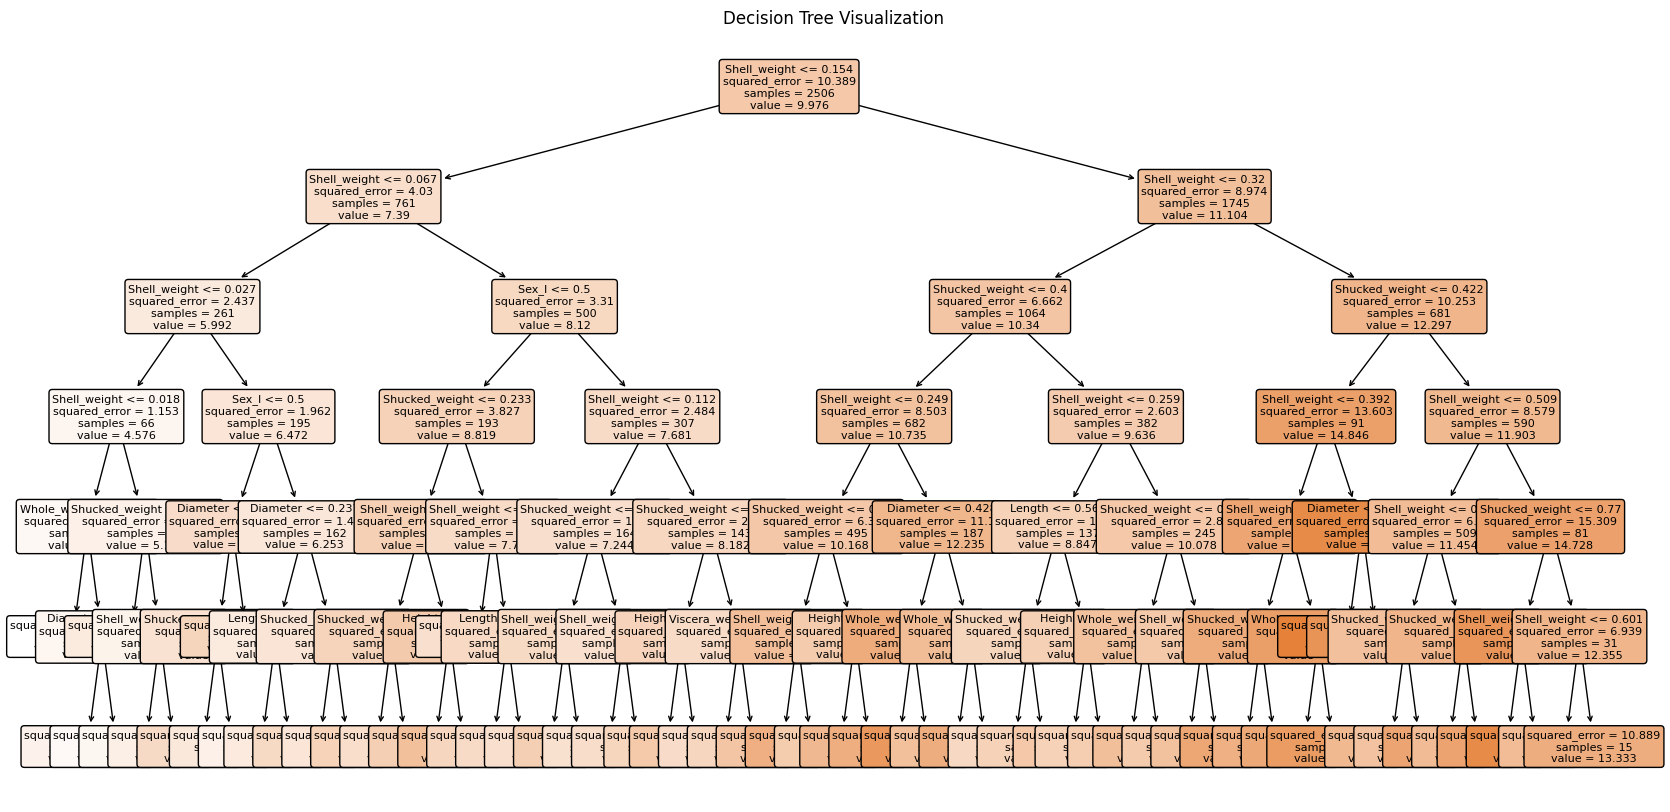

['  IF Shell_weight <= 0.15',
 '    IF Shell_weight <= 0.07',
 '      IF Shell_weight <= 0.03',
 '        IF Shell_weight <= 0.02',
 '          IF Whole_weight <= 0.02',
 '            THEN Predicted value: [[3.33333333]]',
 '          ELSE Whole_weight > 0.02',
 '            IF Diameter <= 0.14',
 '              THEN Predicted value: [[4.90909091]]',
 '            ELSE Diameter > 0.14']

In [42]:

best_tree = DecisionTreeRegressor(**best_params)
best_tree.fit(X_train, y_train)

# 可视化树
plt.figure(figsize=(20, 10))
plot_tree(best_tree,
          feature_names=X_partB.columns,
          filled=True,
          rounded=True,
          fontsize=8)
plt.title("Decision Tree Visualization")
plt.show()

# 提取树的一些规则
def extract_rules(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    def recurse(node, depth, rules):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            rules.append(f"{indent}IF {name} <= {threshold:.2f}")
            recurse(tree_.children_left[node], depth + 1, rules)
            rules.append(f"{indent}ELSE {name} > {threshold:.2f}")
            recurse(tree_.children_right[node], depth + 1, rules)
        else:
            # 对于回归树，叶节点包含预测值
            prediction = tree_.value[node]
            rules.append(f"{indent}THEN Predicted value: {prediction}")

    rules = []
    recurse(0, 1, rules)
    return rules

# 提取一些规则
extracted_rules = extract_rules(best_tree, X_partB.columns)
extracted_rules[:10]  # 展示前10条规则


In [46]:
# 使用最佳参数初始化决策树回归器
best_tree = DecisionTreeRegressor(
    random_state=100,
    max_depth=6,
    min_samples_split=6,
    min_samples_leaf=9
)

# 获取成本复杂度剪枝路径
path = best_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# 使用不同的alpha值和最佳参数训练一系列决策树回归器
regressors = []
for ccp_alpha in ccp_alphas:
    reg = DecisionTreeRegressor(
        random_state=100,
        ccp_alpha=ccp_alpha,
        max_depth=6,
        min_samples_split=6,
        min_samples_leaf=9
    )
    reg.fit(X_train, y_train)
    regressors.append(reg)

# 评估每棵树在测试集上的性能
tree_scores = [reg.score(X_test, y_test) for reg in regressors]

# 寻找最佳alpha和对应的树
best_alpha = ccp_alphas[np.argmax(tree_scores)]
best_reg = regressors[np.argmax(tree_scores)]

# 显示最佳alpha和对应的R²评分
print(best_alpha, np.max(tree_scores))

# 使用最佳 alpha 值和最佳参数训练决策树
best_pruned_tree = DecisionTreeRegressor(
    random_state=100,
    ccp_alpha=best_alpha,
    max_depth=6,
    min_samples_split=6,
    min_samples_leaf=9
)
best_pruned_tree.fit(X_train, y_train)

# 对训练集和测试集进行预测
y_train_pred = best_pruned_tree.predict(X_train)
y_test_pred = best_pruned_tree.predict(X_test)

# 计算性能指标
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# 输出最佳模型的参数和性能指标
best_params = best_tree.get_params()
print("Best Tree Parameters:", best_params)
print(f"Best Test R2: {test_r2:.4f}")
print(f"Best MSE on Train: {train_mse:.4f}")
print(f"Best MSE on Test: {test_mse:.4f}")


0.007436010003045952 0.5184218147922928
Best Tree Parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 9, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'random_state': 100, 'splitter': 'best'}
Best Test R2: 0.5184
Best MSE on Train: 4.3690
Best MSE on Test: 5.0045


## 4

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 初始化随机森林回归模型
rf_model = RandomForestRegressor(
    n_estimators=100,             # 树的数量
    max_depth=6,                  # 最佳树的最大深度
    min_samples_split=6,          # 最佳树的最小样本分裂
    min_samples_leaf=9,           # 最佳树的最小样本叶子
    random_state=100
)

# 训练模型
rf_model.fit(X_train_new, y_train_new)

# 进行预测
y_pred = rf_model.predict(X_test_new)

# 评估模型
# 使用均方误差（MSE）
mse = mean_squared_error(y_test_new, y_pred)
print(f'Mean Squared Error: {mse:.2f}')

# 使用决定系数（R²）
r2 = r2_score(y_test_new, y_pred)
print(f'R² Score: {r2:.2f}')


Mean Squared Error: 0.31
R² Score: 0.55


## 5

In [49]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# 假设 X 和 y 已经定义为特征和目标变量
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_partB, y, test_size=0.4, random_state=100)

# 训练并评估随机森林回归模型
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=6,
    min_samples_split=6,
    min_samples_leaf=9,
    random_state=100
)
rf_model.fit(X_train_new, y_train_new)
rf_mse = mean_squared_error(y_test_new, rf_model.predict(X_test_new))
rf_r2 = r2_score(y_test_new, rf_model.predict(X_test_new))

# 训练并评估梯度提升回归模型
gb_model = GradientBoostingRegressor(
    random_state=100,
    max_depth=6,
    min_samples_split=6,
    min_samples_leaf=9
)
gb_model.fit(X_train_new, y_train_new)
gb_mse = mean_squared_error(y_test_new, gb_model.predict(X_test_new))
gb_r2 = r2_score(y_test_new, gb_model.predict(X_test_new))

# 训练并评估XGBoost回归模型
xgb_model = XGBRegressor(
    random_state=100,
    max_depth=6,
    min_child_weight=6,  # 这是 XGBoost 的类似参数
    eval_metric='mlogloss'
)
xgb_model.fit(X_train_new, y_train_new)
xgb_mse = mean_squared_error(y_test_new, xgb_model.predict(X_test_new))
xgb_r2 = r2_score(y_test_new, xgb_model.predict(X_test_new))

# 打印模型的MSE和R²
print(f"Random Forest - MSE: {rf_mse:.2f}, R²: {rf_r2:.2f}")
print(f"Gradient Boosting - MSE: {gb_mse:.2f}, R²: {gb_r2:.2f}")
print(f"XGBoost - MSE: {xgb_mse:.2f}, R²: {xgb_r2:.2f}")


Random Forest - MSE: 4.61, R²: 0.56
Gradient Boosting - MSE: 4.80, R²: 0.54
XGBoost - MSE: 5.42, R²: 0.48


## 6

In [50]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 创建一个使用Adam优化器的神经网络回归模型
adam_model = MLPRegressor(random_state=100)
adam_model.fit(X_train_new, y_train_new)
adam_predictions = adam_model.predict(X_test_new)
adam_mse = mean_squared_error(y_test_new, adam_predictions)
adam_r2 = r2_score(y_test_new, adam_predictions)

# 创建一个使用SGD优化器的神经网络回归模型
sgd_model = MLPRegressor(solver='sgd', random_state=100)
sgd_model.fit(X_train_new, y_train_new)
sgd_predictions = sgd_model.predict(X_test_new)
sgd_mse = mean_squared_error(y_test_new, sgd_predictions)
sgd_r2 = r2_score(y_test_new, sgd_predictions)

# 输出结果
print(f"MSE with Adam optimizer: {adam_mse:.2f}, R²: {adam_r2:.2f}")
print(f"MSE with SGD optimizer: {sgd_mse:.2f}, R²: {sgd_r2:.2f}")


MSE with Adam optimizer: 4.72, R²: 0.55
MSE with SGD optimizer: 4.72, R²: 0.55
